In [111]:
import pandas as pd
import numpy as np
import datetime as dt
import os, sys
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
from sklearn.preprocessing import scale


from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras import regularizers # type: ignore
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization

## Preparación de datos

In [112]:
df_data = pd.read_csv('data_training/predictores_modelo_futuro.csv')
df_data['Datetime_hour'] = pd.to_datetime(df_data['Datetime_hour'])

df_data['Year'] = df_data['Datetime_hour'].dt.year
df_data['Month'] = df_data['Datetime_hour'].dt.month
df_data['Day_of_Week'] = df_data['Datetime_hour'].dt.dayofweek
df_data['Hour'] = df_data['Datetime_hour'].dt.hour

df_input = df_data.drop(columns=['Datetime_hour'])
print(df_data.info())
df_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_hour     22413 non-null  datetime64[ns]
 1   MD                22413 non-null  float64       
 2   Demanda           22413 non-null  float64       
 3   Gen.Eolica        22413 non-null  float64       
 4   Gen.Fotovoltaica  22413 non-null  float64       
 5   MD_lag_24         22413 non-null  float64       
 6   MD_lag_48         22413 non-null  float64       
 7   MD_lag_1week      22413 non-null  float64       
 8   IDA1_lag_24       21957 non-null  float64       
 9   IDA2_lag_24       22197 non-null  float64       
 10  Hour              22413 non-null  int32         
 11  Month             22413 non-null  int32         
 12  Day_of_week       22413 non-null  int64         
 13  FTB               22413 non-null  float64       
 14  FTS               2241

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week,IDA1_lag_24,IDA2_lag_24,Hour,Month,Day_of_week,FTB,FTS,Precio_Gas,Precio_CO2_lag48,Year,Day_of_Week
0,2023-02-03 00:00:00,125.86,27710.8,4451.0,0.0,119.89,133.65,48.80,117.26,118.39,0,2,4,131.67,121.74,56.06,92.19,2023,4
1,2023-02-03 01:00:00,124.48,25745.8,4191.0,0.0,123.13,121.51,48.00,120.67,117.16,1,2,4,131.67,121.74,56.06,92.19,2023,4
2,2023-02-03 02:00:00,120.01,24538.5,3968.8,0.0,119.00,99.39,35.69,116.60,116.60,2,2,4,131.67,121.74,56.06,92.19,2023,4
3,2023-02-03 03:00:00,107.86,23977.0,3861.0,0.0,118.62,103.79,33.27,115.63,115.53,3,2,4,131.67,121.74,56.06,92.19,2023,4
4,2023-02-03 04:00:00,106.63,23914.5,3710.0,0.0,113.74,110.00,30.00,113.20,113.00,4,2,4,131.67,121.74,56.06,92.19,2023,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22408,2025-08-27 19:00:00,99.00,32531.8,7259.3,6590.3,103.14,114.78,69.27,129.80,132.77,19,8,2,67.93,36.11,33.22,71.48,2025,2
22409,2025-08-27 20:00:00,109.10,32869.3,7047.3,1385.5,117.00,125.95,78.73,127.76,136.32,20,8,2,67.93,36.11,33.22,71.48,2025,2
22410,2025-08-27 21:00:00,114.32,33576.3,6865.5,1.0,123.46,142.00,100.07,122.46,130.87,21,8,2,67.93,36.11,33.22,71.48,2025,2
22411,2025-08-27 22:00:00,113.63,31407.5,6833.3,0.0,113.12,123.11,97.52,114.12,119.91,22,8,2,67.93,36.11,33.22,71.48,2025,2


## Baseline

In [125]:
# Estimacion: Precio igual al día anterior
df_input["MD_pred"] = df_input["MD"].shift(24)
df_clean = df_input.dropna(subset=["MD", "MD_pred"])
mae = mean_absolute_error(df_clean["MD"], df_clean["MD_pred"])
print(mae)

18.749266149113815


In [126]:
# Estimacion: Precio igual al mismo día de la semana anterior
df_input["MD_pred"] = df_input["MD"].shift(24*7)
df_clean = df_input.dropna(subset=["MD", "MD_pred"])
mae = mean_absolute_error(df_clean["MD"], df_clean["MD_pred"])
print(mae)

df_input.drop(columns=["MD_pred"], inplace=True)

27.97921761658031


# Modelo Dense Neural Network

PARAMETROS

In [ ]:
# MEJOR COMBINACION PARA ULTIMOS 14 DIAS  -- 9.09
# n_neurons_1 = 64
# n_neurons_2 = 64
# dropout = 0.25

# lr = 0.0005
# patience = 12
# batch_size = 64
# cols_drop = ['IDA1_lag_24', 'IDA2_lag_24']

In [13]:
num_test_days = 14
num_val_days = 14


n_neurons_1 = 64
n_neurons_2 = 64
dropout = 0.25

lr = 0.0005
patience = 12
batch_size = 64

fecha_inicio = '2024-01-01'

cols_drop = ['IDA1_lag_24', 'IDA2_lag_24']

### Split train - test

In [23]:
df_input = df_data.loc[df_data['Datetime_hour']>=fecha_inicio].drop(columns=['Datetime_hour'])

df_input = df_input.drop(columns=[x for x in cols_drop if x in df_input.columns])
df_input.dropna(inplace=True)
print(df_input.info())


X_train = df_input.drop('MD', axis=1).iloc[:len(df_input)-num_test_days*24-num_val_days*24]
X_val = df_input.drop('MD', axis=1).iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
X_test = df_input.drop('MD', axis=1).iloc[-num_test_days*24:]

y_train = df_input['MD'].iloc[:len(df_input)-num_test_days*24-num_val_days*24]
y_val = df_input['MD'].iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
y_test = df_input['MD'].iloc[-num_test_days*24:]

<class 'pandas.core.frame.DataFrame'>
Index: 14470 entries, 7943 to 22412
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MD                14470 non-null  float64
 1   Demanda           14470 non-null  float64
 2   Gen.Eolica        14470 non-null  float64
 3   Gen.Fotovoltaica  14470 non-null  float64
 4   MD_lag_24         14470 non-null  float64
 5   MD_lag_48         14470 non-null  float64
 6   MD_lag_1week      14470 non-null  float64
 7   Hour              14470 non-null  int32  
 8   Month             14470 non-null  int32  
 9   Day_of_week       14470 non-null  int64  
 10  FTB               14470 non-null  float64
 11  FTS               14470 non-null  float64
 12  Precio_Gas        14470 non-null  float64
 13  Precio_CO2_lag48  14470 non-null  float64
 14  Year              14470 non-null  int32  
 15  Day_of_Week       14470 non-null  int32  
dtypes: float64(11), int32(4), int64(1)
memory 

Normalizacion

In [29]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Para la variable objetivo
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

### Modelo: Dense Neural Network

In [16]:
n_features = X_train.shape[1]

# Entrada
inputs = keras.Input(shape=(n_features,))
# Primera capa interna
x = layers.Dense(n_neurons_1, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Segunda capa interna
x = layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Tercera capa interna
x = layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Salida
outputs = layers.Dense(1)(x)
# Construccion del modelo
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae']  # MAE como métrica principal
)

In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_mae',  # Monitorear MAE de validation
        patience=patience,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'modelo_futuro.keras',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),  # Usar validation set
    epochs=150,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
185/216 [========================>.....] - ETA: 0s - loss: 1.2262 - mae: 0.8537
Epoch 1: val_mae improved from inf to 0.48357, saving model to modelo_futuro.keras
216/216 [==============================] - 2s 3ms/step - loss: 1.1486 - mae: 0.8245 - val_loss: 0.3204 - val_mae: 0.4836
Epoch 2/150
201/216 [==========================>...] - ETA: 0s - loss: 0.5775 - mae: 0.5893
Epoch 2: val_mae improved from 0.48357 to 0.36064, saving model to modelo_futuro.keras
216/216 [==============================] - 0s 2ms/step - loss: 0.5697 - mae: 0.5852 - val_loss: 0.2130 - val_mae: 0.3606
Epoch 3/150
210/216 [============================>.] - ETA: 0s - loss: 0.3934 - mae: 0.4843
Epoch 3: val_mae improved from 0.36064 to 0.34141, saving model to modelo_futuro.keras
216/216 [==============================] - 0s 2ms/step - loss: 0.3915 - mae: 0.4828 - val_loss: 0.2035 - val_mae: 0.3414
Epoch 4/150
193/216 [=========================>....] - ETA: 0s - loss: 0.3024 - mae: 0.4223
Epoch 4: val

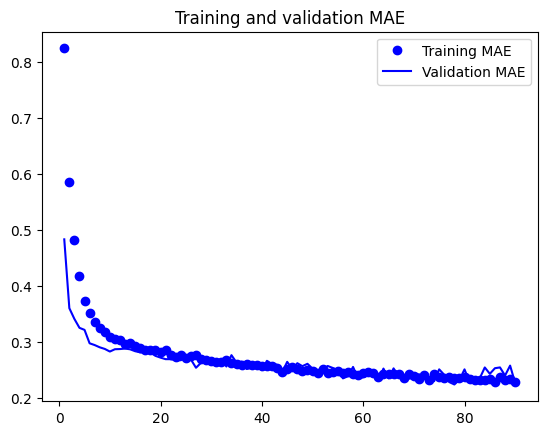

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Evaluacion final

In [20]:
# Evaluar el modelo con el test set (datos nunca vistos)
print("\n" + "="*50)
print("EVALUACIÓN FINAL CON TEST SET")
print("="*50)

# Hacer predicciones en el test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# MAE
mae_test = mean_absolute_error(y_real, y_pred)
print(f"MAE en Test Set: {mae_test:.2f} €/MWh")
print(f"Error absoluto medio: ±{mae_test:.2f} €/MWh")


fechas_test = df_data['Datetime_hour'].iloc[-num_test_days*24:]

# Crear un DataFrame con los datos para Plotly
df_plot = pd.DataFrame({
    'Fecha': fechas_test,
    'Valor Real': y_real,
    'Predicción': y_pred
})

# Crear el gráfico interactivo con Plotly Express
fig = px.line(df_plot, x='Fecha', y=['Valor Real', 'Predicción'],
              title='Predicciones vs Valores Reales (Test Set)',
              labels={'value': 'Precio (Escala Original)', 'variable': 'Leyenda'},
              color_discrete_map={'Valor Real': 'blue', 'Predicción': 'orange'})

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title='Fecha',
    xaxis_title_font_size=14,
    yaxis_title='Precio (Escala Original)',
    yaxis_title_font_size=14,
    legend_title='',
    width=1000,
    height=500,
    template='plotly_white'
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={'name': 'Predicción'})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Mostrar el gráfico
fig.show()


EVALUACIÓN FINAL CON TEST SET
11/11 [==============================] - 0s 617us/step
MAE en Test Set: 9.65 €/MWh
Error absoluto medio: ±9.65 €/MWh


# Tuning de hiperparámetros

Hiperparametros de la preparacion de datos

In [135]:
# PARAMETROS
fecha_inicio = '2023-01-01'
num_test_days = 14
num_val_days = 14
cols_drop = ['IDA2_lag_24', 'IDA1_lag_24']


df_input = df_data.loc[df_data['Datetime_hour']>=fecha_inicio].drop(columns=['Datetime_hour'])

df_input = df_input.drop(columns=[x for x in cols_drop if x in df_input.columns])
df_input.dropna(inplace=True)


X_train = df_input.drop('MD', axis=1).iloc[:len(df_input)-num_test_days*24-num_val_days*24]
X_val = df_input.drop('MD', axis=1).iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
X_test = df_input.drop('MD', axis=1).iloc[-num_test_days*24:]

y_train = df_input['MD'].iloc[:len(df_input)-num_test_days*24-num_val_days*24]
y_val = df_input['MD'].iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
y_test = df_input['MD'].iloc[-num_test_days*24:]


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Para la variable objetivo
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [137]:
class HyperModel_DNN(HyperModel):
    def __init__(self, n_features):
        self.n_features = n_features

    def build(self, hp):
        inputs = keras.Input(shape=(self.n_features,))
        
        # HIPERPARAMETROS
        n_capas = hp.Int('n_capas', min_value=2, max_value=4)
        n_neurons = hp.Choice('n_neurons', values=[64, 128])
        lr = hp.Choice('lr', values=[1e-3, 5e-4])
        dropout = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)

        # Primera capa
        x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
        
        # Resto de capas
        for _ in range(n_capas - 1):  # depende del hp
            x = layers.Dense(n_neurons, activation='relu',
                             kernel_regularizer=regularizers.l2(1e-4))(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(dropout)(x)
        
        # Capa de salida
        outputs = layers.Dense(1)(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        # Compilacion
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='mse',
            metrics=['mae']
        )
        
        return model

In [139]:
n_features = X_train.shape[1]
hypermodel = HyperModel_DNN(n_features=n_features)

tuner = BayesianOptimization(
    hypermodel,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='hp_modelo_futuro_2023_sinIDA'
)
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=10,       
        restore_best_weights=True
    )
]

tuner.search(X_train_scaled, y_train_scaled,
             validation_data=(X_val_scaled, y_val_scaled),
             epochs=150,
             batch_size=32,
             callbacks=callbacks
            )

Trial 15 Complete [00h 01m 23s]
val_mae: 0.2027314230799675

Best val_mae So Far: 0.20120396465063095
Total elapsed time: 00h 23m 17s


In [140]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros:", best_hp.values)

Mejores hiperparámetros: {'n_capas': 3, 'n_neurons': 128, 'lr': 0.0005, 'dropout': 0.1}


### Evaluacion del mejor modelo

In [143]:
# Evaluar el modelo con el test set (datos nunca vistos)
print("="*50)
print("EVALUACIÓN FINAL CON TEST SET")
print("="*50)

# Hacer predicciones en el test set
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# MAE
mae_test = mean_absolute_error(y_real, y_pred)
print(f"MAE en Test Set: {mae_test:.2f} €/MWh")


fechas_test = df_data['Datetime_hour'].iloc[-num_test_days*24:]

# Crear un DataFrame con los datos para Plotly
df_plot = pd.DataFrame({
    'Fecha': fechas_test,
    'Valor Real': y_real,
    'Predicción': y_pred
})

# Crear el gráfico interactivo con Plotly Express
fig = px.line(df_plot, x='Fecha', y=['Valor Real', 'Predicción'],
              title='Predicción del conjunto de Test',
              labels={'value': 'Precio €/MWh', 'variable': 'Leyenda'},
              color_discrete_map={'Valor Real': 'blue', 'Predicción': 'orange'})

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title='Fecha',
    xaxis_title_font_size=14,
    yaxis_title='Precio €/MWh',
    yaxis_title_font_size=14,
    legend_title='',
    width=1000,
    height=500,
    template='plotly_white',
    legend=dict(
        orientation="h",   # Horizontal
        yanchor="bottom",  # Anclar abajo de la leyenda
        y=1.05,            # Posición vertical (un poco arriba del gráfico)
        xanchor="center",  # Anclar al centro
        x=0.5              # Centrar
    )
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={'name': 'Predicción'})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Mostrar el gráfico
fig.show()

EVALUACIÓN FINAL CON TEST SET
11/11 [==============================] - 0s 2ms/step
MAE en Test Set: 7.96 €/MWh
